# Data Mining Project: Online Shoppers Intention
This notebook follows a structured Machine Learning pipeline:
1.  **Data Loading & Initial Cleaning**
2.  **Exploratory Data Analysis (EDA)**
3.  **Data Preprocessing (Splitting & Transformation)**
4.  **Feature Selection**
5.  **Modeling**

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import warnings
import sys

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE

# Configuration
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Aesthetic settings
sns.set(rc={"axes.facecolor":"#FFF0F5","figure.facecolor":"#FFF0F5"})
palette = ["#4B0082", "#800080", "#BA55D3", "#D8BFD8", "#DDA0DD", "#EE82EE"]
cmap = colors.ListedColormap(palette)

In [2]:
# --- 2. DATA LOADING & INITIAL CLEANING ---

# Load Data
df = pd.read_csv("online_shoppers_intention.csv")

# 1. Drop Duplicates
initial_rows = len(df)
df = df.drop_duplicates()
print(f"Removed {initial_rows - len(df)} duplicate rows. Remaining rows: {len(df)}")

# 2. Handle 'Revenue' Target Variable (Convert Bool to Int)
df['Revenue'] = df['Revenue'].astype(int)

# 3. Check for Missing Values
if df.isnull().sum().sum() > 0:
    print("Warning: Missing values detected! Imputation will be handled in the pipeline.")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("No missing values detected.")

df.head()

Removed 125 duplicate rows. Remaining rows: 12205
No missing values detected.


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [4]:
print("The dataset consists of {rows} rows.".format(rows=len(df)))
df.info()


The dataset consists of 12205 rows.
<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int6

## Exploratory Data Analysis (EDA)

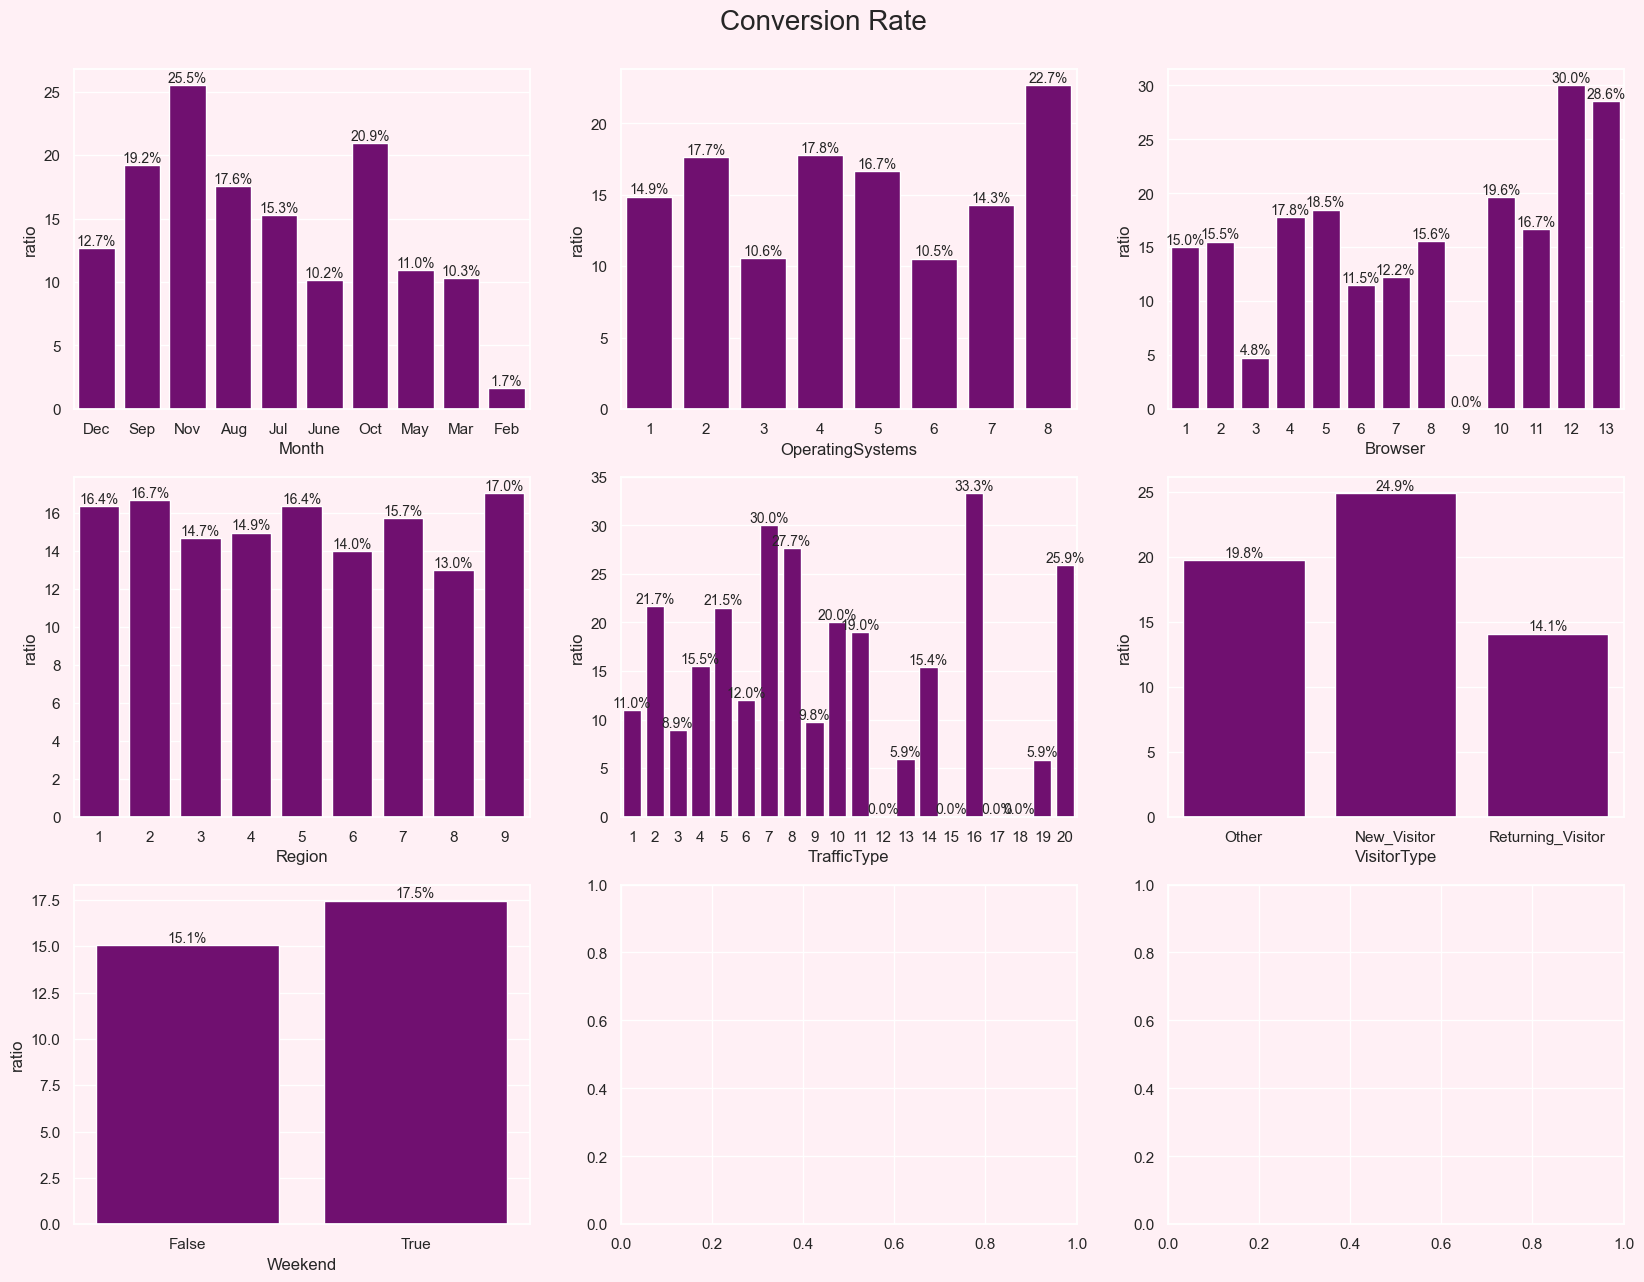

In [5]:
#Setting up color preferences
sns.set(rc={"axes.facecolor":"#FFF0F5","figure.facecolor":"#FFF0F5"}) # LavenderBlush background
cmap = colors.ListedColormap(["#4B0082", "#800080", "#BA55D3", "#D8BFD8", "#DDA0DD", "#EE82EE"]) # Purple shades

cat_columns = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20,15))

counter = 0

#Plotting Conversion Rate for each feature
for cat_column in cat_columns:
    df_count = pd.DataFrame(columns=[cat_column, 'ratio'])

    for t in df[cat_column].unique():
        # Check if revenue is boolean or int (0/1) for filtering
        revenue_mask = (df['Revenue'] == True) | (df['Revenue'] == 1)
        total_count = df[cat_column][df[cat_column]==t].count()
        if total_count > 0:
            value = df[cat_column][df[cat_column]==t][revenue_mask].count() / total_count * 100
        else:
            value = 0
            
        df_count = pd.concat([pd.DataFrame([[t,value]], columns=df_count.columns), df_count], ignore_index=True)
    
    fig_x = counter // 3
    fig_y = counter % 3
    sns.barplot(data=df_count, x=cat_column, y='ratio', ax=axs[fig_x, fig_y], color='#800080') # Purple color
    axs[fig_x, fig_y].bar_label(axs[fig_x, fig_y].containers[0], fmt=lambda x: f'{x:0.1f}%', fontsize=10);

    counter += 1

fig.suptitle("Conversion Rate", fontsize=20, y=0.92)

plt.show()

In [6]:
#Overview of numerical features
df.describe([.01, .5, .99])

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Revenue
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942,2.124211,2.357804,3.153298,4.073904,0.156329
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666,0.906823,1.710114,2.402340,4.016654,0.363182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.001250,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000
99%,14.000000,838.704889,6.000000,722.379200,221.000000,8704.271573,0.200000,0.200000,86.108689,1.000000,4.000000,10.000000,9.000000,20.000000,1.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000


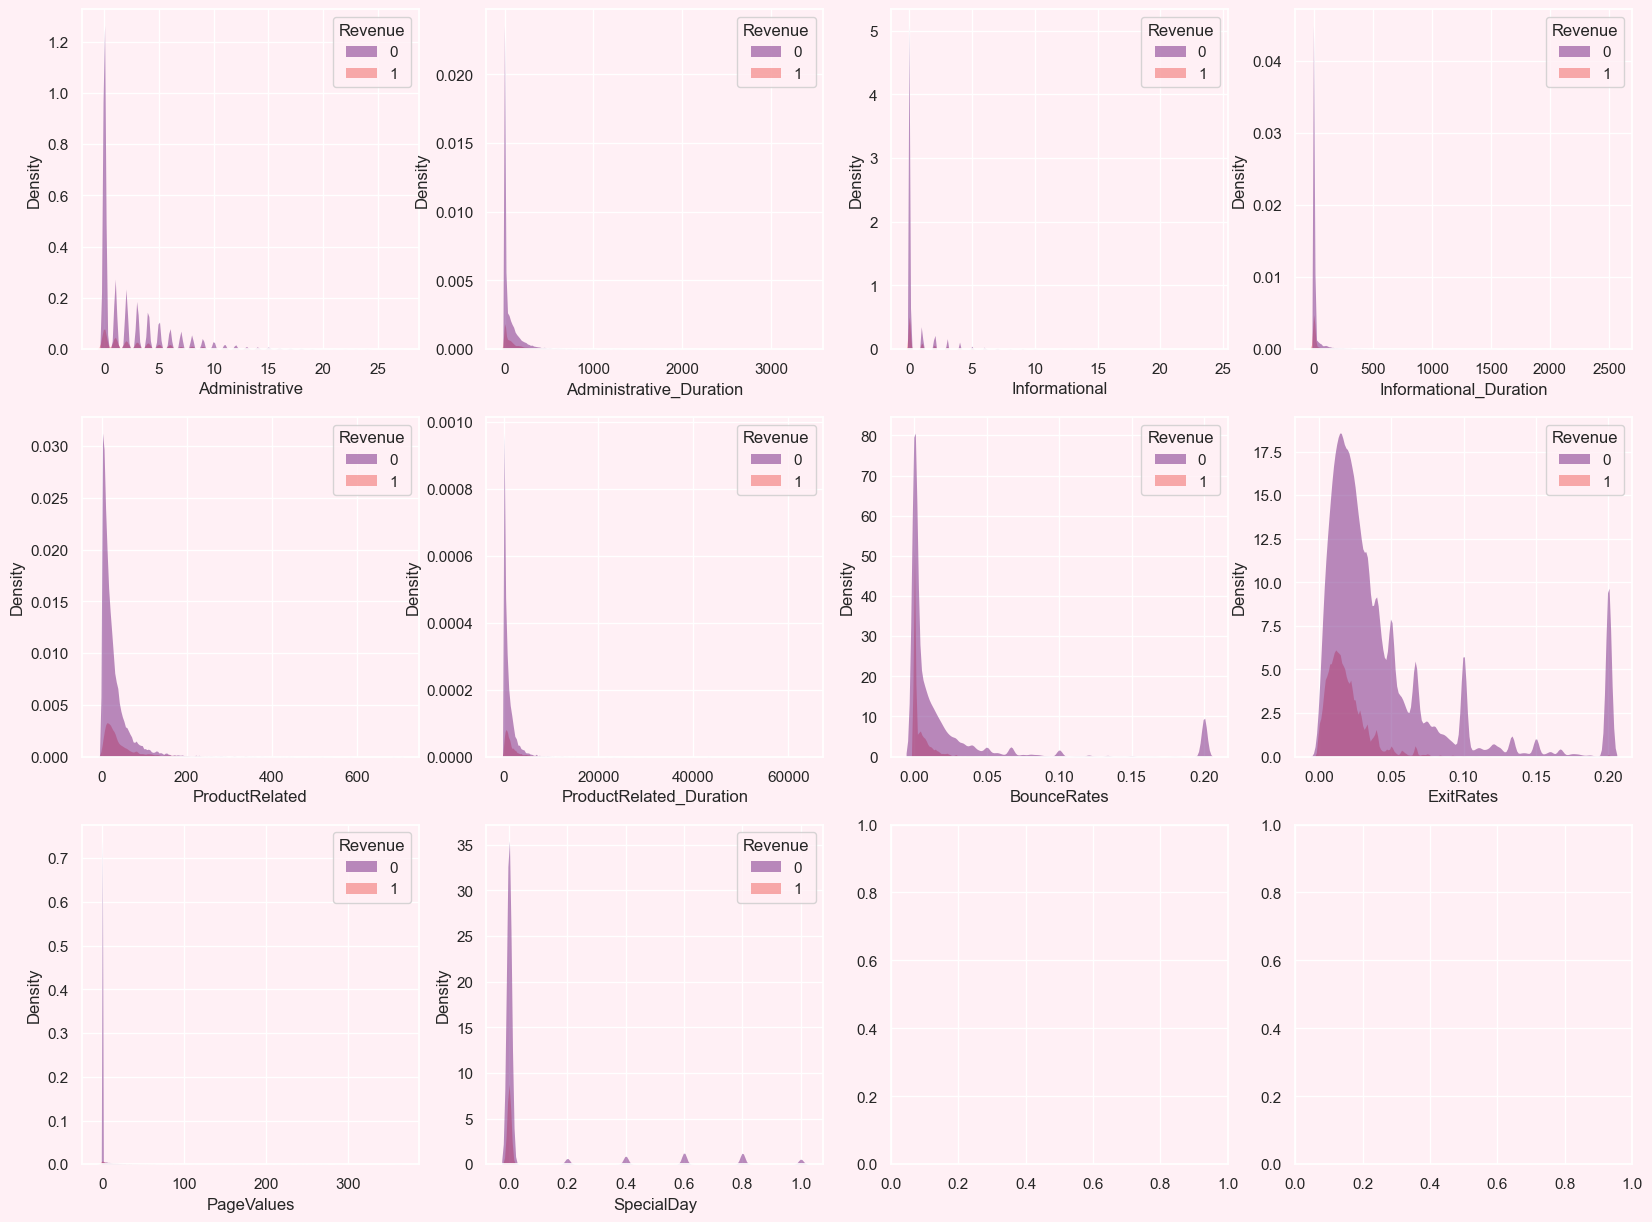

In [7]:
h = (df.dtypes != 'object')
num_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 
'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# Plotting data distribution for numerical features
fig, axs = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(20,15))

counter = 0

for num_column in num_columns:
    fig_x = counter // 4
    fig_y = counter % 4

    sns.kdeplot(data=df, x=num_column, bw_adjust=.25,
     hue='Revenue', palette='magma', # Changed palette to magma
     alpha=.5, linewidth=0, fill=True, 
     ax=axs[fig_x, fig_y])

    counter += 1

In [ ]:
# --- 4. PREPROCESSING PIPELINE & SPLITTING ---

# Identify Feature Types
target_col = 'Revenue'
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
numerical_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
                  'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# Separate X (Features) and y (Target)
X = df.drop(columns=[target_col])
y = df[target_col]

# --- VITAL STEP: Train-Test Split ---
# We split BEFORE transformation to prevent Data Leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# --- DEFINING THE TRANSFORMERS ---

# 1. Numerical Transformer: Imputation + Standard Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing values with Median
    ('scaler', StandardScaler())
])

# 2. Categorical Transformer: Imputation + One-Hot Encoding
# We use handle_unknown='ignore' to avoid errors if the test set has categories not seen in train
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle missing values with Mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False for compatibility with pandas
])

# 3. Combine variables into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    verbose_feature_names_out=False # Keeps column names clean
)

# --- APPLY TRANSFORMATIONS ---

# Fit on Train, Transform on Train and Test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert back to DataFrame for readability and Feature Selection
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Data Transformation (Scaling & Encoding) Complete.")
X_train_df.head()

Training Shape: (9764, 17), Test Shape: (2441, 17)
Data Transformation (Scaling & Encoding) Complete.


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True
0,1.689206,0.676238,0.381750,-0.243015,0.220868,-0.080395,-0.448703,-0.800192,1.665596,-0.311837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.699498,-0.458067,-0.397879,-0.243015,-0.046900,-0.158842,-0.448703,-0.739774,1.495448,-0.311837,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.699498,-0.458067,-0.397879,-0.243015,-0.426237,-0.408089,-0.448703,-0.287446,-0.315264,3.689185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.102322,-0.235218,-0.397879,-0.243015,-0.604748,-0.336795,-0.448703,-0.279507,-0.315264,-0.311837,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.699498,-0.458067,-0.397879,-0.243015,-0.359295,0.203501,-0.448703,-0.609743,-0.315264,-0.311837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Highly Correlated Features to Drop: ['ProductRelated_Duration', 'ExitRates', 'Browser_11', 'VisitorType_Returning_Visitor', 'Weekend_True']
Feature Selection Complete.
Feature count reduced from 74 to 69.


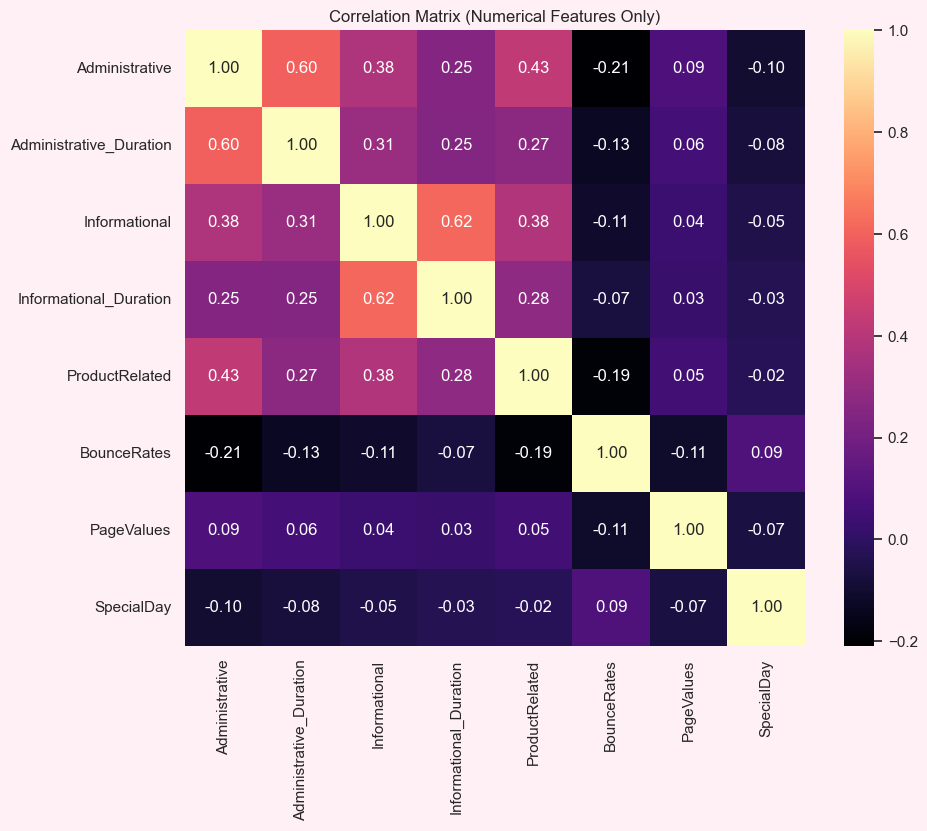

In [ ]:
# --- 5. FEATURE SELECTION & BALANCING (Smote) ---

# A. Feature Selection: correlation-based
# Problem: Multicollinearity (High Correlation)
# We calculate correlation on the Processed Training Set
corr_matrix = X_train_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(f"Highly Correlated Features to Drop: {to_drop}")

# Drop them from both Train and Test
X_train_selected = X_train_df.drop(columns=to_drop)
X_test_selected = X_test_df.drop(columns=to_drop)

print("Feature Selection Complete.")
print(f"Feature count reduced from {X_train_df.shape[1]} to {X_train_selected.shape[1]}.")

# --- VISUALIZATION FIX ---
# Since we have many One-Hot Encoded features, the full heatmap looks "blurry".
# Let's visualize ONLY the Numerical Features to check for multicollinearity clearly.

# Get remaining numerical columns
remaining_num_cols = [col for col in numerical_cols if col in X_train_selected.columns]

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_selected[remaining_num_cols].corr(), cmap='magma', annot=True, fmt=".2f")
plt.title("Correlation Matrix (Numerical Features Only)")
plt.show()

# B. Addressing Class Imbalance (SMOTE)
# We apply SMOTE only on the TRAINING data to synthetically generate minority class samples.
print("\n--- Class Balancing with SMOTE ---")
print("Original Class Distribution:\n", y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print("\nBalanced Class Distribution:\n", y_train_balanced.value_counts(normalize=True))
print(f"Final Training Set Shape: {X_train_balanced.shape}")

# Use X_train_balanced and y_train_balanced for model training
# Use X_test_selected and y_test for evaluation (NEVER balance test set)